In [1]:
import pandas as pd
import numpy as np
import math
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.externals import joblib
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 15]

In [2]:
#read trips data and join it with weather and public holidays dataset
trips = pd.read_csv('../data/modelInput/flowPerHourAndStation.csv')
additional_features = pd.read_csv('../data/modelInput/additionalFeatures.csv')
trips = trips.merge(additional_features, how='left', on=('date_hour'))
del additional_features
trips['date_hour'] = trips['date_hour'].apply(pd.Timestamp) 
trips = trips.set_index('date_hour')

In [3]:
trips.columns

Index(['station_id', 'arrivals', 'departures', 'flow', 'apparentTemperature',
       'cloudCover', 'dewPoint', 'humidity', 'icon', 'precipAccumulation',
       'precipIntensity', 'precipProbability', 'precipType', 'pressure',
       'summary', 'temperature', 'uvIndex', 'visibility', 'windBearing',
       'windSpeed', 'date', 'hour', 'weekday', 'month', 'year',
       'holiday_description', 'is_holiday', 'is_weekend',
       'is_weekend_or_holiday'],
      dtype='object')

In [4]:
features = ['station_id',
            'apparentTemperature', 'cloudCover',
            'dewPoint', 'humidity', 'precipIntensity',
            'precipProbability', 'pressure', 'temperature',
            'uvIndex', 'visibility', 'windBearing', 'windSpeed', 'hour',
            'weekday', 'is_holiday', 'is_weekend', 'is_weekend_or_holiday']

#Split the dataset at 2016-5-1 into training and test data 
test_begin_date = pd.Timestamp(2016, 5, 1)

#Create the trainig and test data for the final model.
X_train = trips[:test_begin_date][features]
X_test = trips[test_begin_date:][features]
y_train = trips[:test_begin_date]['departures']
y_test = trips[test_begin_date:]['departures']

X_train_reduced, y_train_reduced = shuffle(X_train, y_train, n_samples=100000 ,random_state=42)
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

print('Training set size: ', X_train.shape[0])
print('Test set size: ', X_test.shape[0])
print('Reduced training set size: ', X_train_reduced.shape[0])

Training set size:  1045415
Test set size:  611184
Reduced training set size:  100000


In [5]:
#Creates a XGBoost model from the parameters given in the sklearn wrapper.
def train_XGBModel(model, X_train, y_train, X_test, y_test, learning_rate=.005):
    #get parameters from slearn wrapper
    xgb_param = model.get_xgb_params()
    
    #set parameters for native XGBoost
    xgb_param['eval_metric'] = 'rmse'
    xgb_param['learning_rate'] = learning_rate
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
    booster = xgb.train(xgb_param,
                        dtrain,
                        num_boost_round=100000,
                        evals=watchlist,
                        early_stopping_rounds=100,
                        verbose_eval=500)
    return booster

In [6]:
#Number of parallel jobs
n_jobs=16

#Cross-validation fold number
cv_folds=5

#MSE scorer for cross-validation
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

#Grid search for given sklearn wrapper and parameters
def grid_search(model, parameters, X_train, y_train):
    gsearch = GridSearchCV(estimator=model, 
                           param_grid=parameters,
                           scoring=mse_scorer,
                           cv=cv_folds, 
                           n_jobs=n_jobs,
                           verbose=2)
    gsearch.fit(X_train, y_train)
    print('Best parameters: ', gsearch.best_params_)
    print('Best score: ', gsearch.best_score_)
    
    #return the best model
    return gsearch.best_estimator_

In [7]:
#sklearn wrapper for XGBoost with initial parameters 
basic_model = XGBRegressor(
    booster='gbtree',
    learning_rate=0.1,
    gamma=0,
    max_depth=3,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8, 
    reg_lambda=1,
    reg_alpha=0,
    scale_pos_weight=1,
    objective='count:poisson',
    nthread=16,
    seed=42)

In [8]:
#Evaluate the performance of an XGBooster based on the initial parameters
basic_xgb = train_XGBModel(basic_model, X_train, y_train, X_test, y_test, .005)

[0]	train-rmse:2.20731	valid-rmse:2.56347
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[500]	train-rmse:1.87065	valid-rmse:2.14938
[1000]	train-rmse:1.78978	valid-rmse:2.05754
[1500]	train-rmse:1.72842	valid-rmse:1.98733
[2000]	train-rmse:1.68582	valid-rmse:1.93835
[2500]	train-rmse:1.65679	valid-rmse:1.90735
[3000]	train-rmse:1.63281	valid-rmse:1.88277
[3500]	train-rmse:1.61186	valid-rmse:1.8601
[4000]	train-rmse:1.59155	valid-rmse:1.83886
[4500]	train-rmse:1.57115	valid-rmse:1.81903
[5000]	train-rmse:1.55553	valid-rmse:1.80317
[5500]	train-rmse:1.54296	valid-rmse:1.79108
[6000]	train-rmse:1.53329	valid-rmse:1.78206
[6500]	train-rmse:1.5234	valid-rmse:1.77226
[7000]	train-rmse:1.5152	valid-rmse:1.76442
[7500]	train-rmse:1.50638	valid-rmse:1.75673
[8000]	train-rmse:1.49957	valid-rmse:1.75045
[8500]	train-rmse:1.49269	valid-rmse:1.74418
[9000]	train-rmse:1.48595	valid-rmse:1.73822
[9500]

In [11]:
dtest = xgb.DMatrix(X_test)
y_predict = basic_xgb.predict(dtest)
print('Results on test set')
print('Root mean squared error: %2.3f' % math.sqrt(mean_squared_error(y_predict, y_test)))
print('R^2 score: %2.3f' % r2_score(y_predict, y_test))

NameError: name 'basic_xgb' is not defined

In [11]:
#Grid search starts here

param_test_1 = {
 'max_depth': [3, 5, 7, 9],
 'min_child_weight': [1, 4, 7, 10, 13]
}

basic_model.set_params(n_estimators=500)
best_model_1 = grid_search(basic_model, param_test_1, X_train_reduced, y_train_reduced)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:  3.1min
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed: 37.1min finished


Best parameters:  {'max_depth': 5, 'min_child_weight': 1}
Best score:  -2.01941269976


In [12]:
param_test_2 = {
 'max_depth': [4, 5, 6],
 'min_child_weight': [1, 2, 3]
}

best_model_2 = grid_search(best_model_1, param_test_2, X_train_reduced, y_train_reduced)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:  4.5min
[Parallel(n_jobs=16)]: Done  37 out of  45 | elapsed: 13.7min remaining:  3.0min
[Parallel(n_jobs=16)]: Done  45 out of  45 | elapsed: 14.5min finished


Best parameters:  {'max_depth': 5, 'min_child_weight': 3}
Best score:  -2.00867804731


In [13]:
param_test_3 = {
 'gamma': [i/10.0 for i in range(0, 11)]
}

best_model_3 = grid_search(best_model_2, param_test_3, X_train_reduced, y_train_reduced)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:  4.0min
[Parallel(n_jobs=16)]: Done  52 out of  55 | elapsed: 12.5min remaining:   43.0s
[Parallel(n_jobs=16)]: Done  55 out of  55 | elapsed: 12.6min finished


Best parameters:  {'gamma': 0.0}
Best score:  -2.00867804731


In [14]:
param_test_4 = {
 'subsample': [.4, .6, .8, 1],
 'colsample_bytree': [.4, .6, .8, 1]
}

best_model_4 = grid_search(best_model_3, param_test_4, X_train_reduced, y_train_reduced)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:  3.9min
[Parallel(n_jobs=16)]: Done  80 out of  80 | elapsed: 22.0min finished


Best parameters:  {'colsample_bytree': 1, 'subsample': 1}
Best score:  -1.96801337061


In [15]:
param_test_5 = {
 'subsample': [.9, 1],
 'colsample_bytree': [.9, 1]
}

best_model_5 = grid_search(best_model_4, param_test_5, X_train_reduced, y_train_reduced)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=16)]: Done  11 out of  20 | elapsed:  4.7min remaining:  3.9min
[Parallel(n_jobs=16)]: Done  20 out of  20 | elapsed:  5.4min finished


Best parameters:  {'colsample_bytree': 1, 'subsample': 1}
Best score:  -1.96801337061


In [16]:
param_test_6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

best_model_6 = grid_search(best_model_5, param_test_6, X_train_reduced, y_train_reduced)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=16)]: Done   7 out of  25 | elapsed:  5.8min remaining: 15.0min
[Parallel(n_jobs=16)]: Done  20 out of  25 | elapsed:  9.0min remaining:  2.2min
[Parallel(n_jobs=16)]: Done  25 out of  25 | elapsed:  9.3min finished


Best parameters:  {'reg_alpha': 1}
Best score:  -1.96153109146


In [17]:
param_test_7 = {
 'reg_alpha': [.5, 1, 50]
}

best_model_7 = grid_search(best_model_6, param_test_7, X_train_reduced, y_train_reduced)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=16)]: Done   8 out of  15 | elapsed:  3.7min remaining:  3.2min
[Parallel(n_jobs=16)]: Done  15 out of  15 | elapsed:  4.2min finished


Best parameters:  {'reg_alpha': 1}
Best score:  -1.96153109146


In [18]:
best_model_7.get_xgb_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0.0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 3,
 'missing': None,
 'n_estimators': 500,
 'nthread': 16,
 'objective': 'count:poisson',
 'reg_alpha': 1,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 42,
 'silent': 1,
 'subsample': 1}

In [7]:
best_model_7 = XGBRegressor(
    booster='gbtree',
    learning_rate=0.1,
    gamma=0,
    max_depth=5,
    min_child_weight=3,
    subsample=1,
    colsample_bytree=1, 
    reg_lambda=1,
    reg_alpha=1,
    scale_pos_weight=1,
    objective='count:poisson',
    nthread=16,
    seed=42)

In [8]:
#Grid search done. Train and evaluate final model.

final_model = train_XGBModel(best_model_7, X_train, y_train, X_test, y_test, .005)

[0]	train-rmse:2.2067	valid-rmse:2.56272
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[500]	train-rmse:1.77827	valid-rmse:2.04232
[1000]	train-rmse:1.64724	valid-rmse:1.90067
[1500]	train-rmse:1.57461	valid-rmse:1.82795
[2000]	train-rmse:1.5191	valid-rmse:1.77089
[2500]	train-rmse:1.48911	valid-rmse:1.74278
[3000]	train-rmse:1.46395	valid-rmse:1.7199
[3500]	train-rmse:1.4419	valid-rmse:1.69969
[4000]	train-rmse:1.42735	valid-rmse:1.68752
[4500]	train-rmse:1.4122	valid-rmse:1.67524
[5000]	train-rmse:1.40127	valid-rmse:1.66761
[5500]	train-rmse:1.38369	valid-rmse:1.65248
[6000]	train-rmse:1.3736	valid-rmse:1.64488
[6500]	train-rmse:1.36708	valid-rmse:1.64122
[7000]	train-rmse:1.35904	valid-rmse:1.63496
[7500]	train-rmse:1.35177	valid-rmse:1.63073
[8000]	train-rmse:1.34584	valid-rmse:1.62808
[8500]	train-rmse:1.33864	valid-rmse:1.62386
[9000]	train-rmse:1.33396	valid-rmse:1.62109
[9500]	tr

In [9]:
final_model.save_model('../models/boosterDepartures.xgbm')

In [13]:
dtest = xgb.DMatrix(X_test)
y_predict = final_model.predict(dtest)
print('Results on test set')
print('Root mean squared error: %2.3f' % math.sqrt(mean_squared_error(y_predict, y_test)))
print('R^2 score: %2.3f' % r2_score(y_predict, y_test))

Results on test set
Root mean squared error: 1.604
R^2 score: 0.244


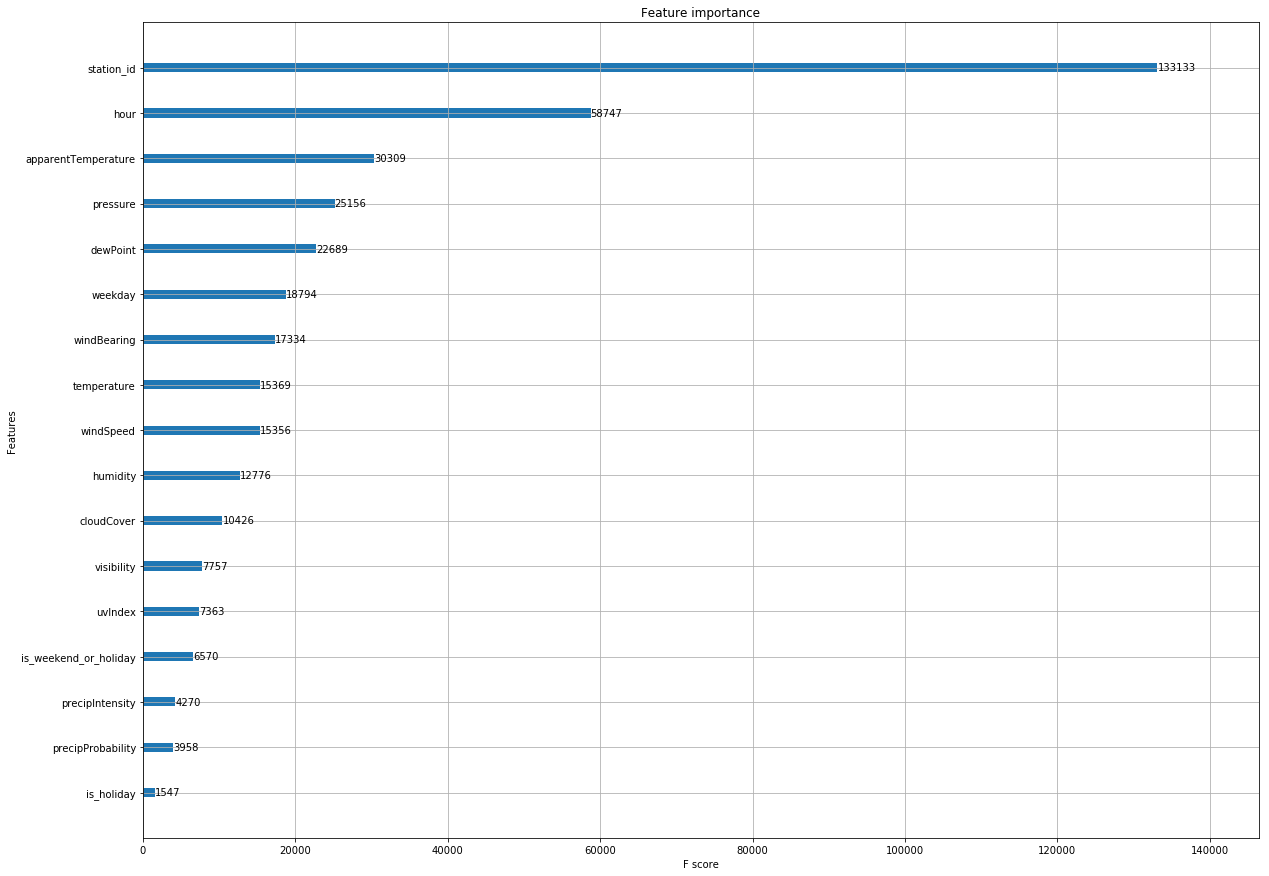

In [12]:
xgb.plot_importance(final_model)